Following code can be refferenced to understand in  how to convert 
an audio files to extract Mel Frequecy Ceptral Cofficients.
Basic preprocessign like envoloping (low pass filtering) are also been done to extract 
good meaningful ingo from the audio.

# Importing required libraries.

In [2]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank

## Plotting functions

In [ ]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1


In [2]:
#csv containg files name and their instrument type
df=pd.read_csv('ins.csv')

In [3]:
df.set_index('fname',inplace=True)

In [4]:
#using wavfile library to import audio file along with the sampling rate
#creating an additional column for length of audio file
for f in df.index:
    rate,signal=wavfile.read('wavfiles/'+f)
    df.at[f,'length']=signal.shape[0]/rate

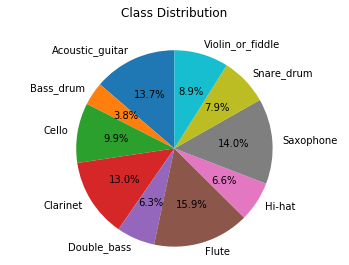

In [5]:
#plotting a pie chart to understand class distribution based on total length of audio available for respective instruments
classes=list(np.unique(df.label))
class_dist=df.groupby(['label'])['length'].mean()

fig,ax=plt.subplots()
ax.set_title('Class Distribution',y=1.08)
ax.pie(class_dist,labels=class_dist.index,autopct='%1.1f%%',shadow=False,startangle=90)
ax.axis('equal')
plt.show()
df.reset_index(inplace=True)


In [9]:
def cal_fft(y,rate):
    n=len(y)
    freq=np.fft.rfftfreq(n,d=1/rate)
    Y=abs(np.fft.rfft(y)/n)
    return (Y,freq)

In [7]:
# Librosa is a very help library while working with audio data.
import librosa as lr

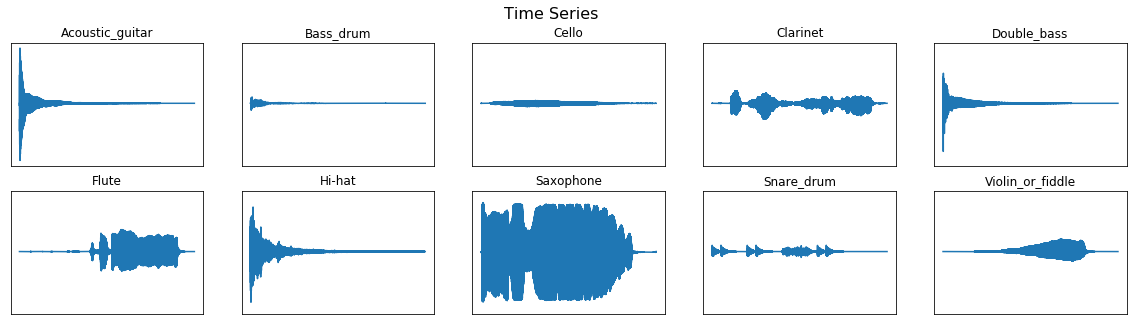

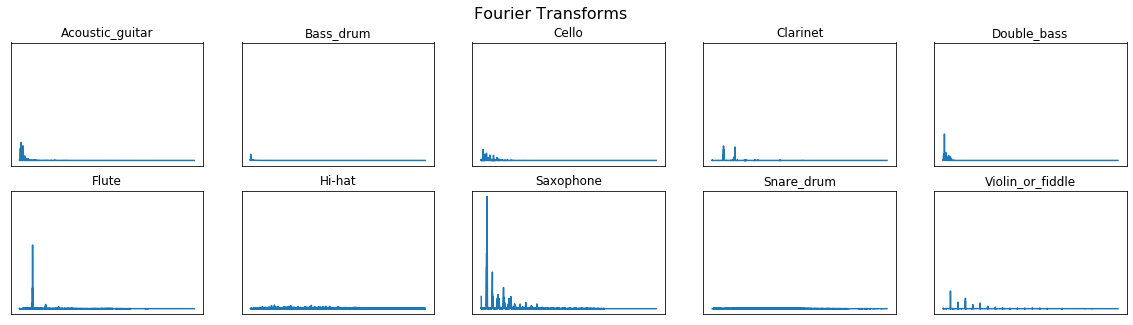

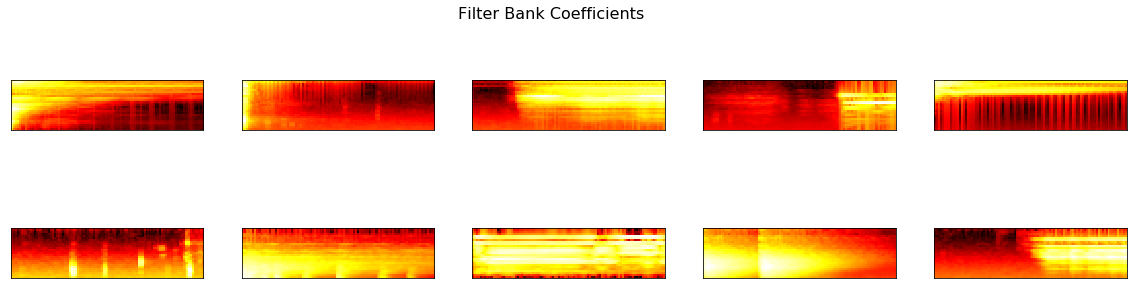

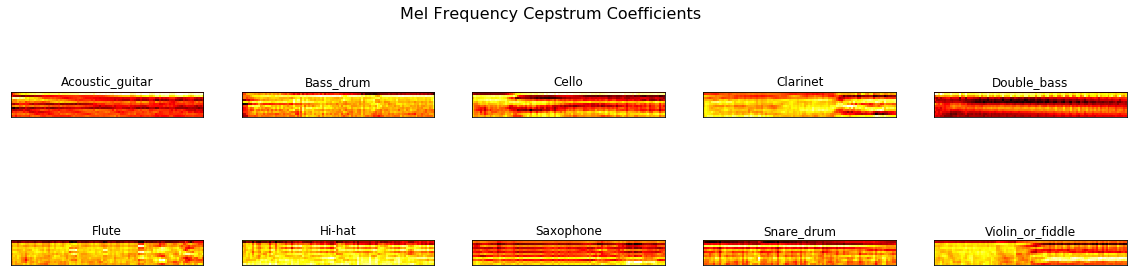

In [21]:
#class wise saving the mfccs and other features in a dictionary and then plotting them 
signals={}
fft={}
fbank={}
mfccs={}

for c in classes:
    wav_file=df[df['label']==c].iloc[0,0]
    signal,rate=lr.load('wavfiles/'+wav_file,sr=44100)
    signals[c]=signal
    fft[c]=cal_fft(signal,rate)
    bank=logfbank(signal[:rate],rate,nfilt=26,nfft=1103).T
    fbank[c]=bank
    mel=mfcc(signal[:rate],rate,numcep=13,nfilt=26,nfft=1103).T
    mfccs[c]=mel
    
plot_signals(signals)
plt.show()
plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()



In [29]:
#creating a low pass filter to remove initial pauses (lower limit threshold)
def envelope(y,rate,threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean=y.rolling(window=int(rate/10),min_periods=1,center=True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

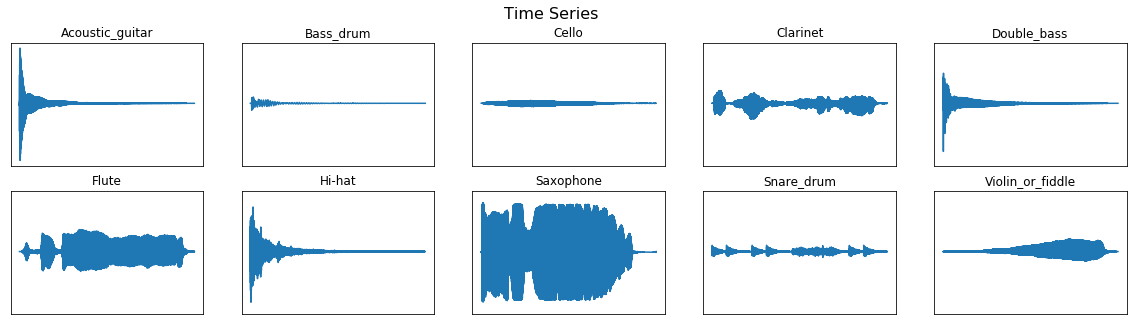

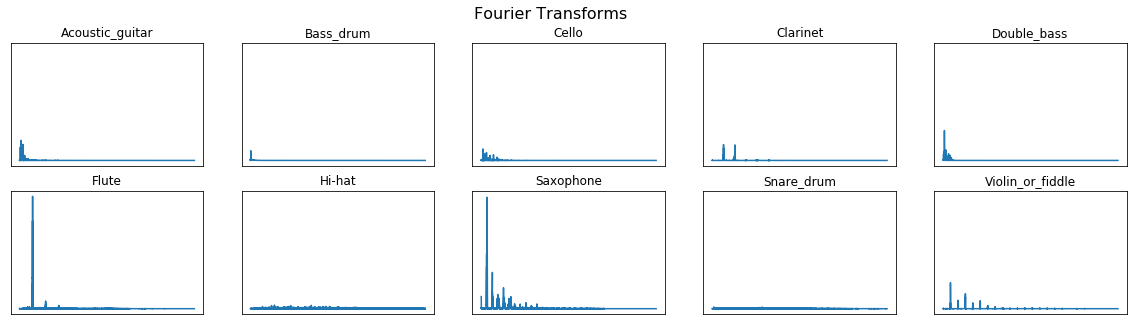

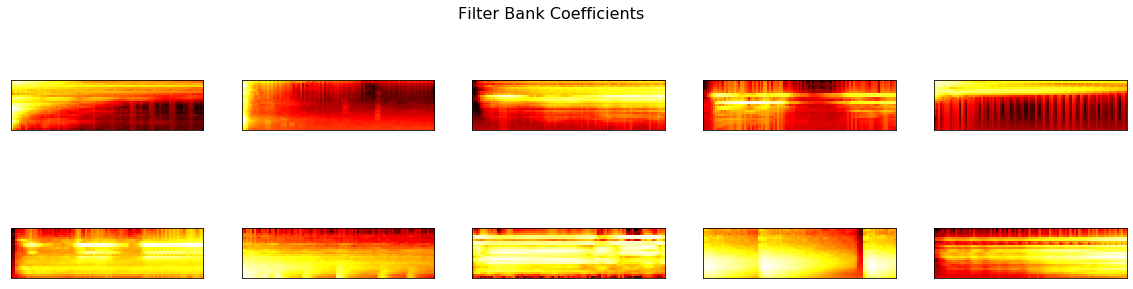

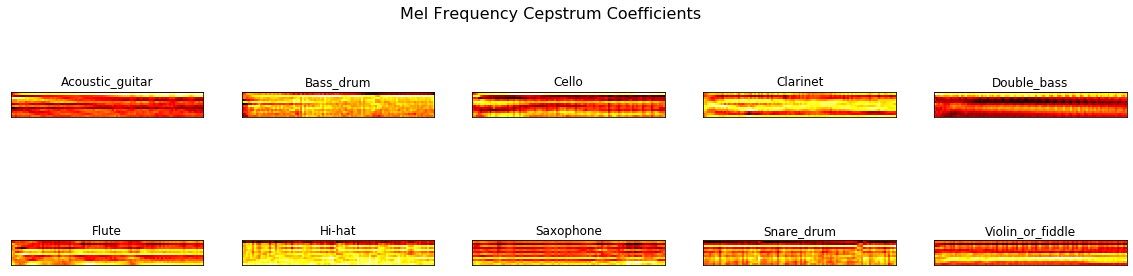

In [30]:
#doing the same thing as above , but this time if you the time series graphs you will be able to see the changes done by passing the audio file through a low pass filter
signals={}
fft={}
fbank={}
mfccs={}

for c in classes:
    wav_file=df[df['label']==c].iloc[0,0]
    signal,rate=lr.load('wavfiles/'+wav_file,sr=44100)
    mask=envelope(signal,rate,0.0005)
    signal=signal[mask]
    signals[c]=signal
    fft[c]=cal_fft(signal,rate)
    bank=logfbank(signal[:rate],rate,nfilt=26,nfft=1103).T
    fbank[c]=bank
    mel=mfcc(signal[:rate],rate,numcep=13,nfilt=26,nfft=1103).T
    mfccs[c]=mel
    
plot_signals(signals)
plt.show()
plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()



In [34]:
#saving the all the preprocessed file that can be fetched into a CNN
if len(os.listdir('clean'))==0:
    for f in tqdm(df.fname):
        signal,rate=lr.load('wavfiles/'+f, sr=16000)
        mask=envelope(signal,rate,0.0005)
        wavfile.write(filename='clean/'+f,rate=rate,data=signal[mask])

100%|████████████████████████████████████████| 300/300 [01:19<00:00,  4.31it/s]
